<a href="https://colab.research.google.com/github/salmanromeo/System_Identification/blob/main/Lorenz96_Pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pyro to solve Lorenz 96 model**

**Install Pyro in the system**

In [ ]:
pip install pyro-ppl

**Import libraries**

In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

**Lorenz 96 model**

#####We consider the following ODE:
\begin{align}
        \dot{X}_k = X_{k-1} (X_{k+1} - X_{k-2}) - X_{k} + 10
    \end{align}
#####Initially we use $RK4$ to solve this ODE and generate data.

**Define Lorenz 96 model and RK4**

In [3]:
def lorenz96(x, F):
    N = len(x)
    dxdt = torch.zeros(N)
    for k in range(N):
        dxdt[k] = (x[(k + 1) % N] - x[(k - 2)% N]) * x[(k - 1)% N] - x[k] + F
    return dxdt

def rk4(x, F, dt):
    k1 = lorenz96(x, F)
    k2 = lorenz96(x + 0.5 * dt * k1, F)
    k3 = lorenz96(x + 0.5 * dt * k2, F)
    k4 = lorenz96(x + dt * k3, F)
    x_new = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_new

**Set parameters**

In [4]:
# Set the number of States
N = 40

# Set the initial condition
x0 = torch.rand(N)

# Set the forcing term
F = 10.0

# Set the integration parameters
dt = 0.005;
t_start = 5.0
t_end = 10.0

# Create an array to store the time steps
t_steps = torch.arange(t_start, t_end, dt)
num_steps = len(t_steps)

# Create arrays to store the solutions
x_solution = torch.zeros((num_steps, N))
x_solution[0] = x0

# Number Of Parameters (For 2 neighbouring nodes)
N_P = 21; 

**Solve with RK4**

In [5]:
# Perform the integration
for n in range(1, num_steps):
    x_solution[n] = rk4(x_solution[n - 1], F, dt)

X_state = x_solution  # True state values

**True RHS**

In [6]:
# True RHS
RHS_true = torch.zeros((num_steps, N))
for k in range(N):
    RHS_true[:,k]=(x_solution[:,(k + 1) % N] - x_solution[:,(k - 2)% N]) * x_solution[:,(k - 1)% N] - x_solution[:,k] + F

dx_dt_state = RHS_true  # True RHS

**Plot the Lorenz 96 model's states**

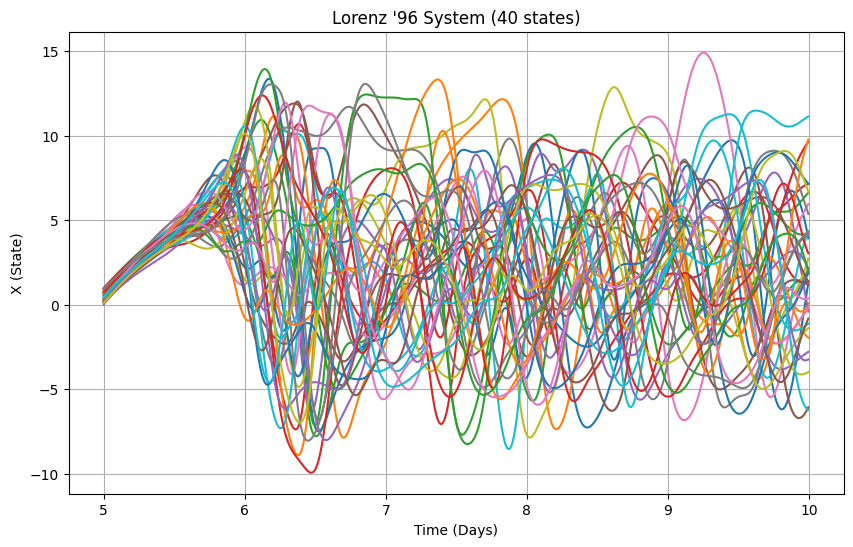

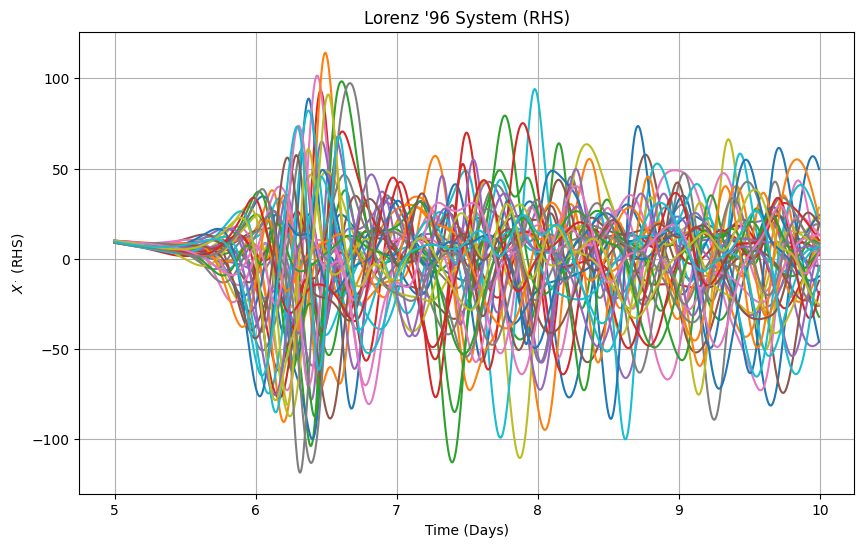

In [7]:
# Plot the solutions (X_state and X_dot)
plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, X_state[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')
plt.xlabel('Time (Days)')
plt.ylabel('X (State)')
plt.title('Lorenz \'96 System (40 states)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, RHS_true[:, k], label=f'Variable {k+1}')
    plt.xlabel('Time')
plt.xlabel('Time (Days)')
plt.ylabel('$X^{.}$ (RHS)')
plt.title('Lorenz \'96 System (RHS)')
#plt.legend()
plt.grid(True)
plt.savefig('X_state_dot.png', dpi=300)
plt.show()

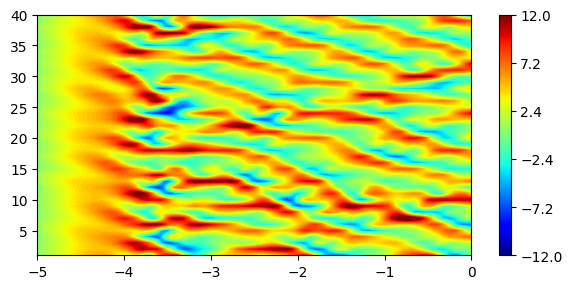

In [8]:
#%%
ns = int(t_start/dt)
nt = int(t_end/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time
ti = np.linspace(-t_start,0,ns)
t = np.linspace(0,t_end,nt)
tobs = np.linspace(0,t_end,nb)
x = np.linspace(1,N,N)

Xi,Ti = np.meshgrid(x,ti,indexing='ij')

vmin = -12
vmax = 12
fig, ax = plt.subplots(figsize=(6,3))
cs = ax.contourf(Ti,Xi,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax,ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

**Define our assumed dynamics**

#####We will assume that it will be a function of any possible quadratic feature that are a function of $x_{k-2}$, $x_{k-1}$, $x_{k}$, $x_{k+1}$ and $x_{k+2}$.
#####Or, we can say that:
\begin{align}
        RHS = d_0+d_{1}X_{k-2}+d_{2}X_{k-1}+d_{3}X_{k}+d_{4}X_{k+1}+d_{5}X_{k+2}+d_{6}X_{k-2}X_{k-1}+d_{7}X_{k-2}X_{k}+d_{8}X_{k-2}X_{k+1}+d_{9}X_{k-2}X_{k+2}+d_{10}X_{k-1}X_{k}+d_{11}X_{k-1}X_{k+1}+d_{12}X_{k-1}X_{k+2}+d_{13}X_{k}X_{k+1}+d_{14}X_{k}X_{k+2}+d_{15}X_{k+1}X_{k+2}+d_{16}X_{k-2}^2+d_{17}X_{k-1}^2+d_{18}X_{k}^2+d_{19}X_{k+1}^2+d_{20}X_{k+2}^2
    \end{align}

In [9]:
# Define the assumed dynamics:
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

**Set the observed data for Pyro**

In [10]:
# Set the observed data
X_observed = np.vstack([
    X_state[:, (k - 2) % N].numpy(),
    X_state[:, (k - 1) % N].numpy(),
    X_state[:, k].numpy(),
    X_state[:, (k + 1) % N].numpy(),
    X_state[:, (k + 2) % N].numpy(),
]).T
Y_observed = dx_dt_state[:, k].numpy()

# Convert the observed data to PyTorch tensors
X_observed = torch.tensor(X_observed)
Y_observed = torch.tensor(Y_observed)

**Define the Pyro model**

In [11]:
# Define the Pyro model
def model(X_observed, Y_observed):
    N_P = 21  # Number of parameters
    d = pyro.sample("d", dist.Normal(torch.zeros(N_P), 2 * torch.ones(N_P)))
    mu = func(X_observed.T, d)
    pyro.sample("Y", dist.Normal(mu, 1.0), obs=Y_observed)

# Perform Bayesian inference with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc.run(X_observed, Y_observed)

# Get the posterior samples
posterior_samples = mcmc.get_samples()
estimated_params = posterior_samples["d"].mean(dim=0)
print("Estimated parameters:", estimated_params)

Sample: 100%|██████████| 2000/2000 [07:19,  4.55it/s, step size=6.47e-02, acc. prob=0.920]

Estimated parameters: tensor([ 9.8810e+00,  2.4222e-02,  7.0221e-03, -9.8719e-01,  1.7041e-02,
         1.2218e-02, -1.0010e+00, -1.0558e-03, -2.8131e-03, -9.7495e-04,
        -8.3718e-04,  9.9905e-01,  5.5502e-04, -1.5221e-03, -7.5111e-04,
        -1.0578e-03, -1.1641e-03,  3.8830e-04,  1.1816e-03, -3.8697e-04,
        -2.4565e-04])


**Plot the posterior distribution with reference values**

<Figure size 800x600 with 0 Axes>

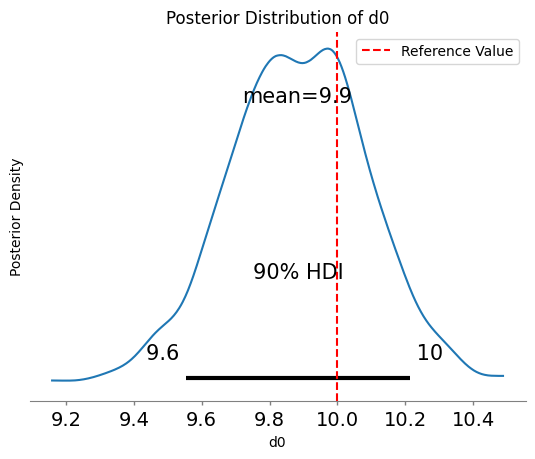

<Figure size 800x600 with 0 Axes>

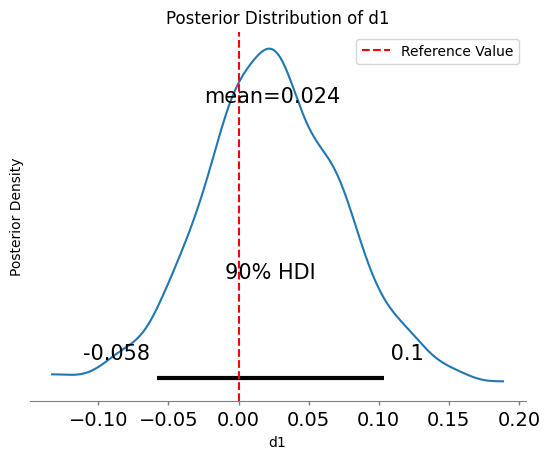

<Figure size 800x600 with 0 Axes>

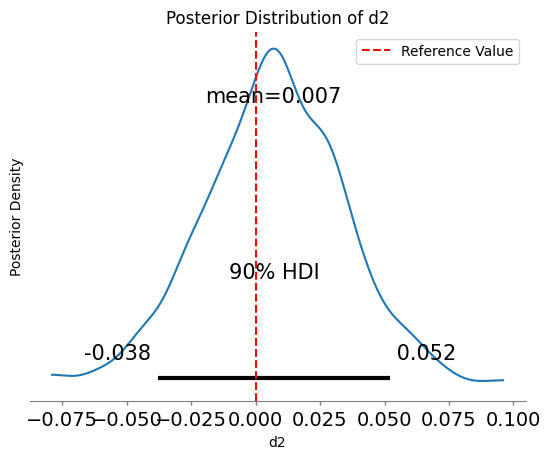

<Figure size 800x600 with 0 Axes>

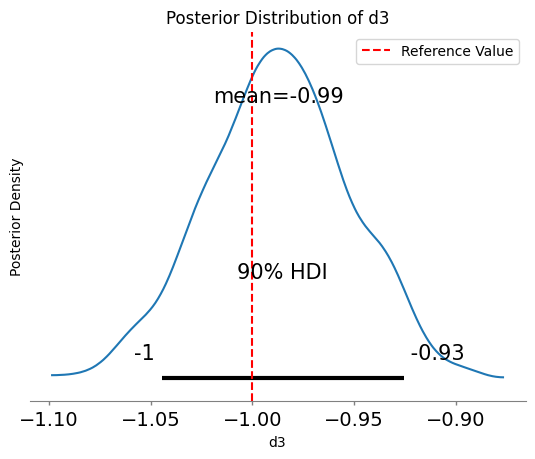

<Figure size 800x600 with 0 Axes>

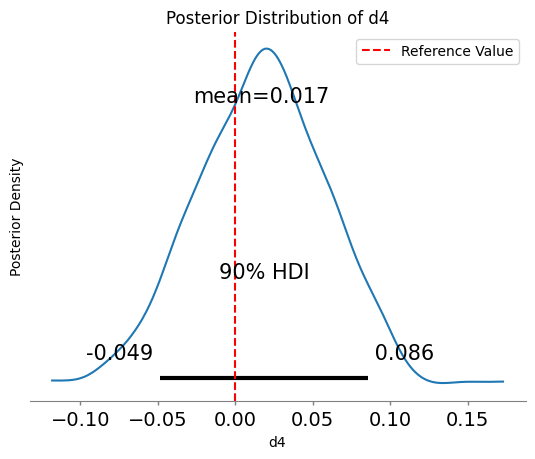

<Figure size 800x600 with 0 Axes>

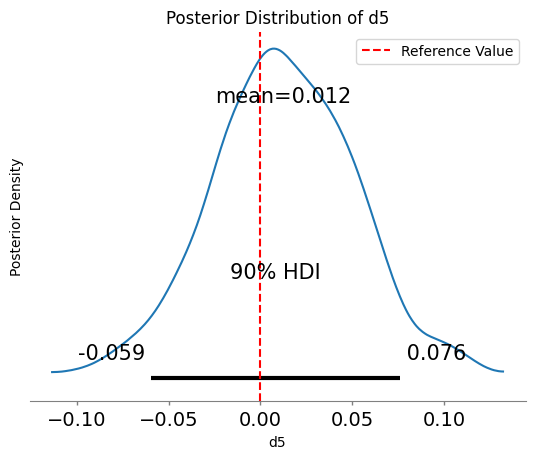

<Figure size 800x600 with 0 Axes>

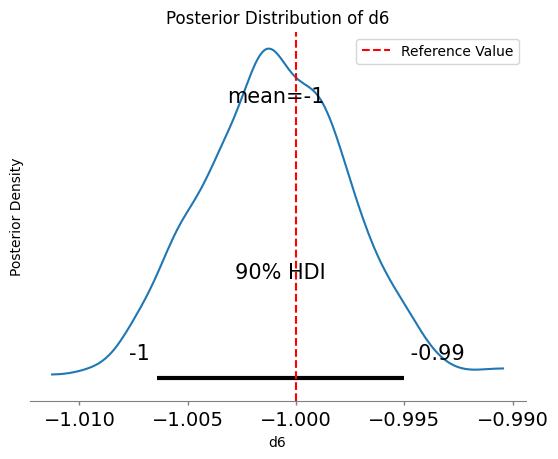

<Figure size 800x600 with 0 Axes>

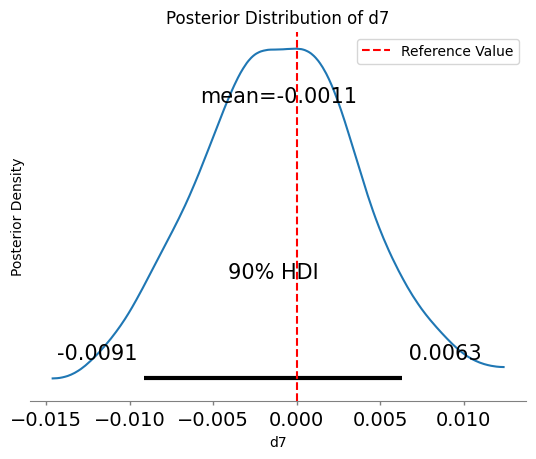

<Figure size 800x600 with 0 Axes>

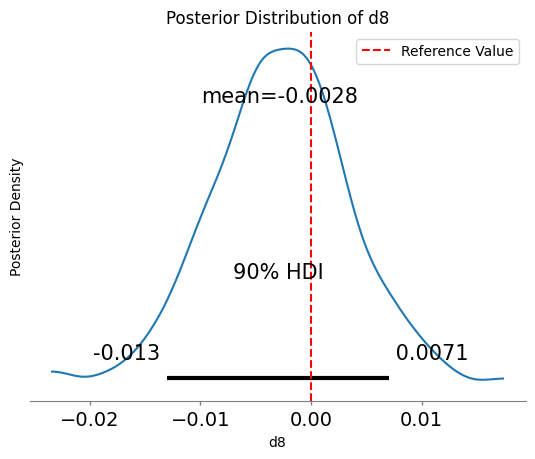

<Figure size 800x600 with 0 Axes>

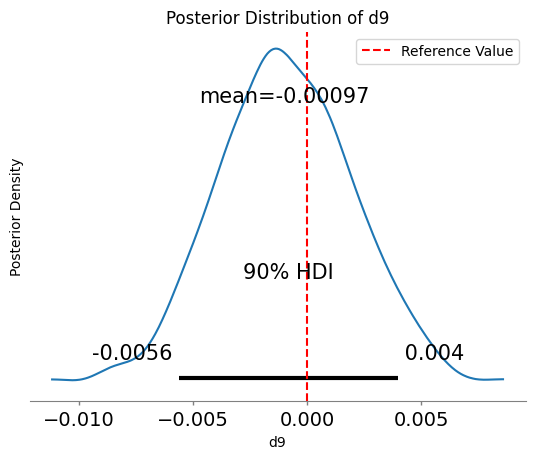

<Figure size 800x600 with 0 Axes>

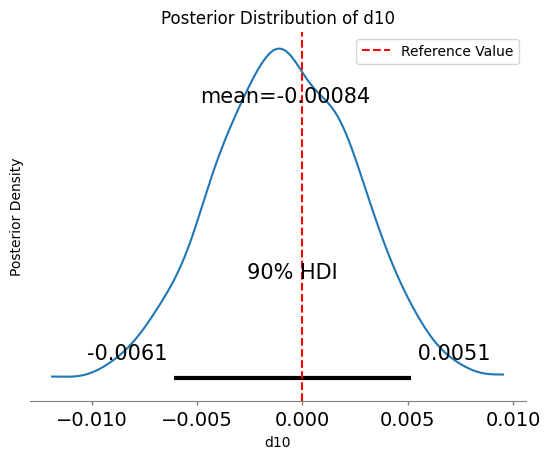

<Figure size 800x600 with 0 Axes>

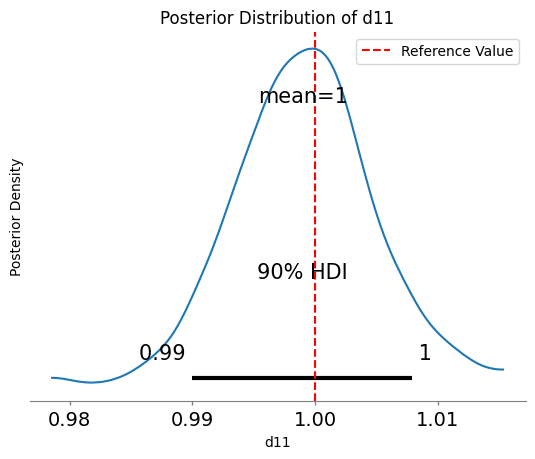

<Figure size 800x600 with 0 Axes>

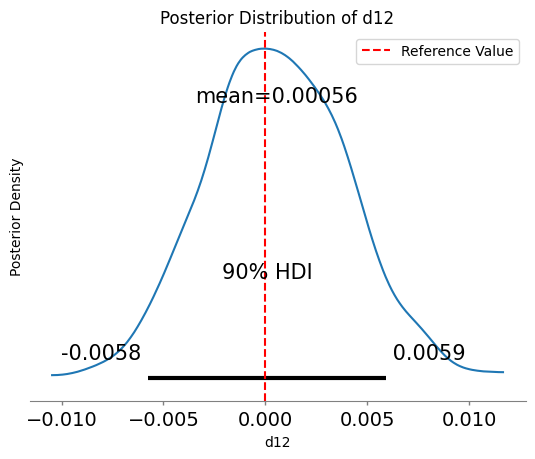

<Figure size 800x600 with 0 Axes>

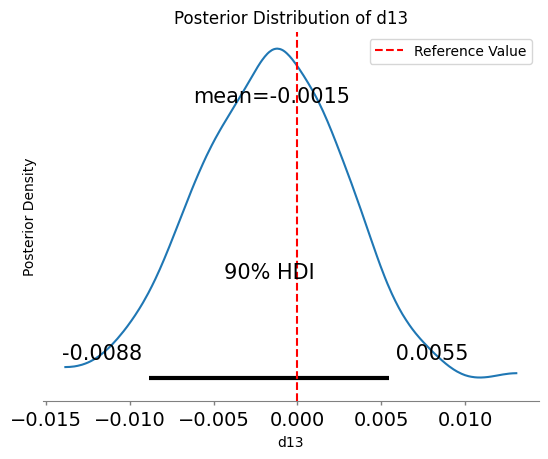

<Figure size 800x600 with 0 Axes>

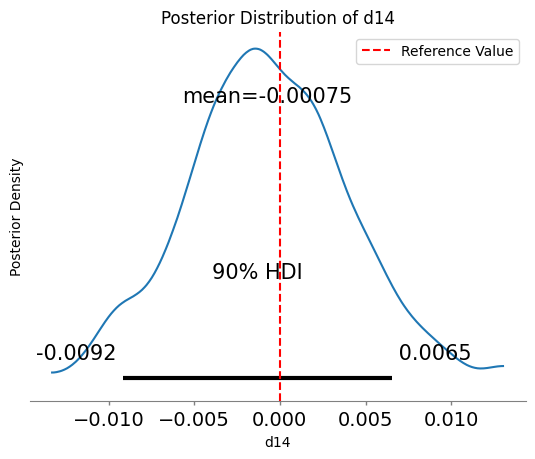

<Figure size 800x600 with 0 Axes>

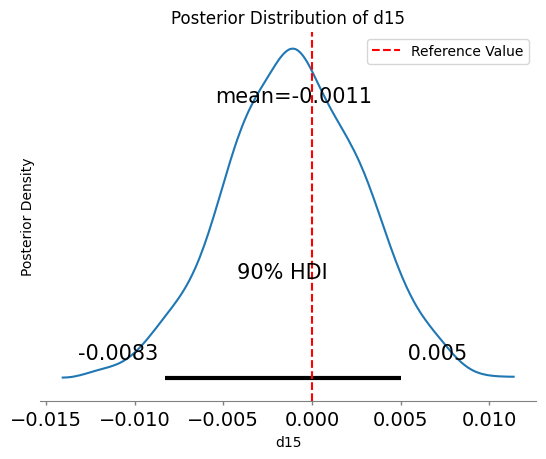

<Figure size 800x600 with 0 Axes>

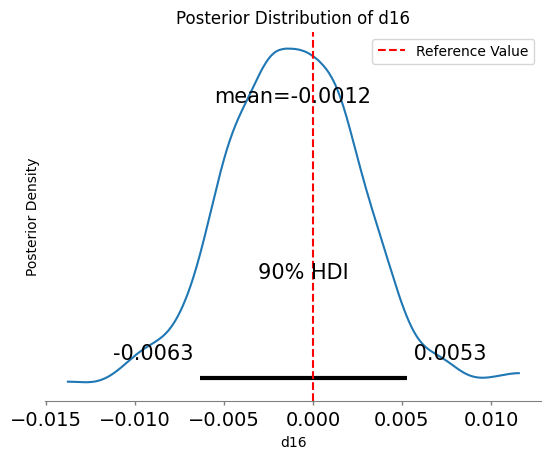

<Figure size 800x600 with 0 Axes>

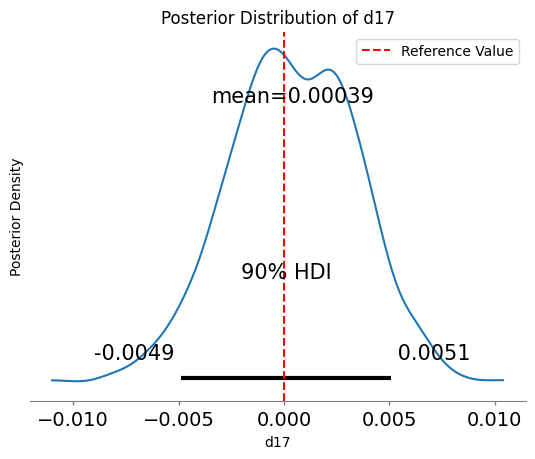

<Figure size 800x600 with 0 Axes>

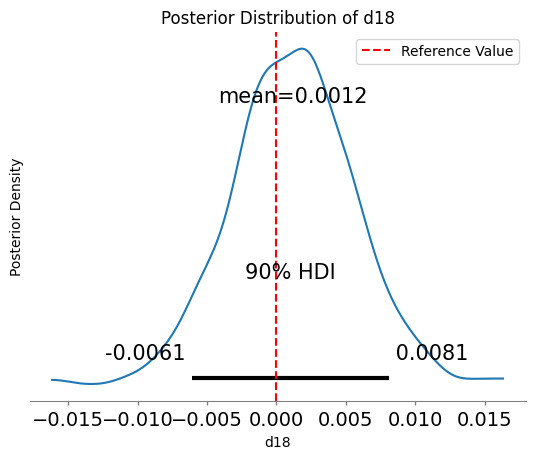

<Figure size 800x600 with 0 Axes>

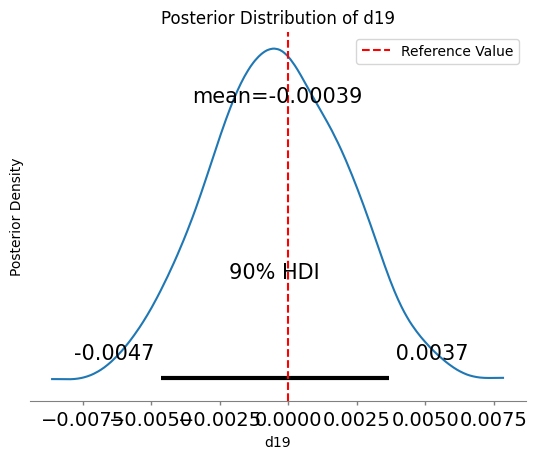

<Figure size 800x600 with 0 Axes>

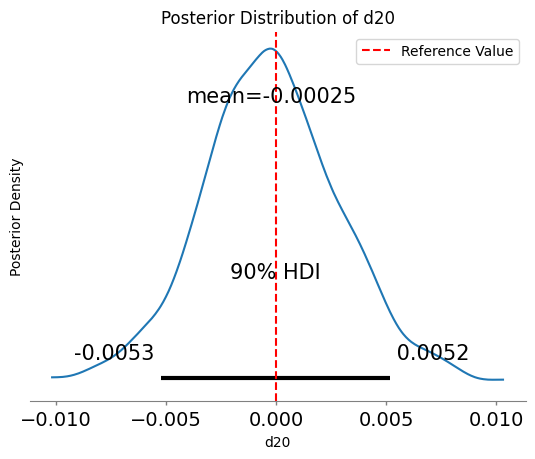

In [24]:
import arviz as az

# Define reference values for each parameter
ref_vals = [10, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Plot the posterior distribution of d0 to d20 separately
for i in range(21):
    plt.figure(figsize=(8, 6))
    az.plot_posterior(posterior_samples["d"].numpy()[:, i], hdi_prob=0.9)
    plt.axvline(x=ref_vals[i], color='red', linestyle='--', label='Reference Value')
    plt.xlabel(f"d{i}")
    plt.ylabel("Posterior Density")
    plt.title(f"Posterior Distribution of d{i}")
    plt.legend()
    plt.show()

In [ ]:
# Use the estimated parameter values
estimated_params = posterior_samples["d"].mean(axis=0).numpy()

# Define the assumed dynamics with estimated parameter values
def func(X, d):
    return (
        d[0] + d[1] * X[0] + d[2] * X[1] + d[3] * X[2] + d[4] * X[3] + d[5] * X[4] +
        d[6] * X[0] * X[1] + d[7] * X[0] * X[2] + d[8] * X[0] * X[3] + d[9] * X[0] * X[4] +
        d[10] * X[1] * X[2] + d[11] * X[1] * X[3] + d[12] * X[1] * X[4] +
        d[13] * X[2] * X[3] + d[14] * X[2] * X[4] +
        d[15] * X[3] * X[4] +
        d[16] * X[0]**2 + d[17] * X[1]**2 + d[18] * X[2]**2 + d[19] * X[3]**2 + d[20] * X[4]**2
    )

# Create arrays to store the solutions with estimated parameters
x_solution_estimated = torch.zeros((num_steps, N))
x_solution_estimated[0] = x0

# Perform the integration with estimated parameters
for n in range(1, num_steps):
    x_solution_estimated[n] = rk4(x_solution_estimated[n - 1], F, dt)

X_state_estimated = x_solution_estimated  # Estimated state values

# Calculate the estimated RHS
RHS_estimated = torch.zeros((num_steps, N))
for k in range(N):
    RHS_estimated[:, k] = func(
        torch.stack([
            X_state_estimated[:, (k - 2) % N],
            X_state_estimated[:, (k - 1) % N],
            X_state_estimated[:, k],
            X_state_estimated[:, (k + 1) % N],
            X_state_estimated[:, (k + 2) % N]
        ]),
        estimated_params
    )

# Plot the solutions (X_state and X_dot) with estimated parameters
plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, X_state_estimated[:, k], label=f'Variable {k+1}')
plt.xlabel('Time (Days)')
plt.ylabel('X (State)')
plt.title('Lorenz \'96 System (Estimated State)')
plt.grid(True)
#plt.legend(loc=(1.05,0.5))
plt.show()

plt.figure(figsize=(10, 6))
for k in range(N):
    plt.plot(t_steps, RHS_estimated[:, k], label=f'Variable {k+1}')
plt.xlabel('Time (Days)')
plt.ylabel('$X^{.}$ (RHS)')
plt.title('Lorenz \'96 System (Estimated RHS)')
plt.grid(True)
#plt.legend(loc=(1.05,0.5))
plt.show()

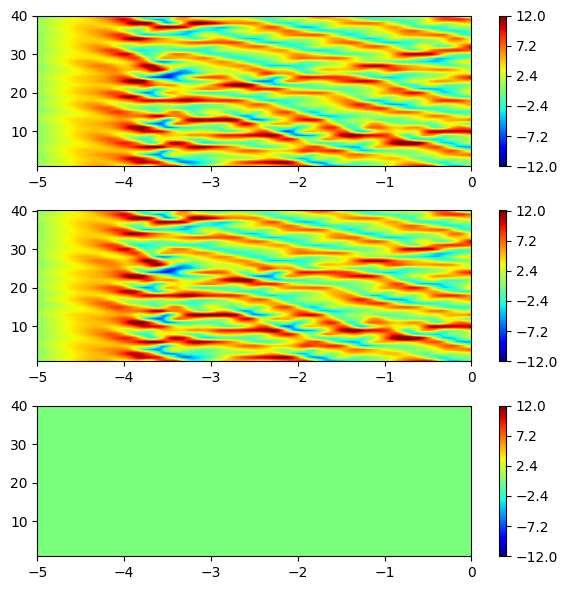

In [35]:
#%%
ns = int(t_start/dt)
nt = int(t_end/dt)
fr = 10.0
nf = 10         # frequency of observation
nb = int(nt/nf) # number of observation time
ti = np.linspace(-t_start,0,ns)
t = np.linspace(0,t_end,nt)
tobs = np.linspace(0,t_end,nb)
x = np.linspace(1,N,N)

Xi,Ti = np.meshgrid(x,ti,indexing='ij')

vmin = -12
vmax = 12
fig, ax = plt.subplots(3,1,figsize=(6,6))
cs = ax[0].contourf(Ti,Xi,X_state.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[0],ticks=np.linspace(vmin, vmax, 6))

cs = ax[1].contourf(Ti,Xi,X_state_estimated.T,120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array(X_state_estimated.T)
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[1],ticks=np.linspace(vmin, vmax, 6))

cs = ax[2].contourf(Ti,Xi,(X_state.T-X_state_estimated.T),120,cmap='jet',vmin=vmin,vmax=vmax)
m = plt.cm.ScalarMappable(cmap='jet')
m.set_array((X_state.T-X_state_estimated.T))
m.set_clim(vmin, vmax)
fig.colorbar(m,ax=ax[2],ticks=np.linspace(vmin, vmax, 6))

fig.tight_layout()
plt.show()

#####In our research, we aimed to estimate the coefficients of the Lorenz '96 system, specifically focusing on $d_0$, $d_3$, $d_6$, and $d_{11}$. We hypothesized that these coefficients should ideally be equal to $10$, $-1$, $-1$, and $1$, respectively, while the remaining coefficients should be close to zero.

#####However, after analyzing the data and running our estimation model, we found that the estimated values for $d_0$, $d_3$, $d_6$, and $d_{11}$ were $9.9$, $-0.98$, $-1$, and $1$, respectively. Interestingly, the estimated values for the other coefficients were not as close to zero as we initially anticipated.

#####This diversity in the coefficient values introduced some adjustments to our assumed dynamics. Surprisingly, despite the deviations from our initial expectations, the adjusted dynamics still managed to closely match the true solution of the Lorenz '96 system. This suggests that the system's behavior is more resilient and adaptable to variations in the coefficient values than we initially assumed.

#####These findings highlight the complexity of the Lorenz '96 system and its sensitivity to parameter values. Further research and analysis are warranted to gain deeper insights into the underlying mechanisms that allow the system to exhibit such flexibility and robustness.